# "Single-column" set for Test 2: ecRad input file creation.

### Test 2: Cloud Geometrical Depth

#### Version 7a: 2024-07-31

Preparing matrix of 1D columns .nc file and formatting for input ecRad file (Useful for TripleClouds Solver).

Fixed parameters:
1. Radiative Transfer Model: ecRad.
2. Tropical sounding (Lapse Rate of $6.7\;K/km$ (see on next cells below)).
3. Cosine of solar zenith angle: $\mu = 0.6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006).
4. SW albedo: $\alpha = 0.05$ (Hartmann & Berry, 2017).
5. LW emissivity: $\epsilon = 0.97$ (REFERENCE?).
6. Skin temperature as surface temperature: $T_{skin} = 300 K$ (290 to 300 K (Jin & Dickinson, 2010)).
7. Gases: CO$_2$ = 390.1ppm, CH$_4$ = 1.8ppm, N$_2$O = 322ppb, O$_2$ = 0.20942ppm, from 2012 climatology used in ICON run scripts.
8. No liquid water.
9. No aerosols.
10. Solver: Tripleclouds.

Variable parameters:
1. Macro:  Temperature from 236 K to 200 K for cloud middle level (Associated with Position-Altitude).
2. Macro (<b>TEST 2</b>): $\Delta h$ (0.5 km to 5 km every 0.25 km (Nellore, Kannan, Vellaisamy 2019)).
3. Macro: Ice Water Path (IWP) = 30 $g/m^2$ (Around Anvil Cirrus IWP typical value (Sokol & Hartmann 2020)):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz} \;=\; 30\;\frac{g}{m^2}\;\;\; , \;\;\;(h_2 - h_1 = \Delta h \;(km))$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/kg)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = \frac{30\;g/m^2}{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$
4. Micro: Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).
5. Ice Optical Schemes (index associated with config file):
        5.1 Fu 1996 and Fu, Yang & Sun 1998 (1O).
        5.2 Yi et al. 2013 (2O).
        5.3 Baran et al. 2016 (3O).
        5.4 Baran et al. 2014 (4O).

### Loading Libraries

In [55]:
import numpy as np # Version used here: 1.23.4 (python 3.8.15)
import pandas as pd # Version used here: 1.5.2 (python 3.8.15)
import xarray as xr # Version used here: 2022.11.0 (python 3.8.15)
from scipy import interpolate # Version used here: 1.10.0 (python 3.8.15)

import matplotlib.pyplot as plt # Version used here: 3.6.2 (python 3.8.15)
from matplotlib import cm

%matplotlib notebook

## Checking tropical sounding

Directories from UofArizona HPC server:

In [2]:
tropical_profile = pd.read_csv('tropical_profile_ellingson_250m.txt', sep = '\s+ ', engine = 'python')

In [3]:
temp            = tropical_profile['temperature (K)'].iloc[::-1]
altitude        = tropical_profile['height (km)'].iloc[::-1] # If this is over sea level, we can use altitude.
tropopause_i    = temp.argmin()
tropopause      = temp.iloc[tropopause_i]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]

print('Tropopause: ', tropopause, ' K at ', altitude.iloc[tropopause_i], ' km')
print('Melting Layer: ', altitude.iloc[melting_layer_i], ' km')

Tropopause:  195.6  K at  17.0  km
Melting Layer:  4.75  km


### Density Profile $(kg/m^3)$

In [4]:
R = 287 # J/kgK
density_0 = (tropical_profile['pressure (hPa)']*100)/(tropical_profile['temperature (K)']*R)
density   = density_0.iloc[::-1]

Estimating Lapse Rate:

In [5]:
DT = tropical_profile['temperature (K)'][30] - tropical_profile['temperature (K)'][20]
Dh = tropical_profile['height (km)'][30] - tropical_profile['height (km)'][20]
slope = DT/Dh
print('Lapse Rate: ',slope,' K/km')

Lapse Rate:  -6.7  K/km


## Preparing input table

List of parameters:

- Skin Temperature (for each temperature-perturbation level)
- cos_solar_zenith_angle (for each temperature-perturbation level)
- pressure_hl (half level column)
- temperature_hl (half level column)
- q or h2o_mmr (Specific Humidity (kg/kg)) (level column)
- o3_mmr (Ozone Mass Mixing Ratio (kg/kg)) (level column)
- co2_vmr (mol/mol) (scalar)
- ch4_vmr (mol/mol) (scalar)
- n2o_vmr (mol/mol) (scalar)
- o2_vmr (mol/mol) (scalar)
- q_liquid (Liquid cloud mass mixing ratio (kg/kg)) (level column)
- q_ice (Ice cloud mass mixing ratio (kg/kg)) (level column)
- re_liquid (m) (level column)
- re_ice (m) (level column)
- cloud_fraction (level column)
- sw_albedo (1 value)
- lw_emissivity (1 value)

### 1. Half Level Pressures (Pa)

"The half_level dimension corresponds to the mid-points of the levels, plus the top-of-atmosphere and surface, and so must be one more than level"

In [6]:
pressure_hli = [tropical_profile['pressure (hPa)'].iloc[-1]*100] # Pa
for i in range(len(tropical_profile['pressure (hPa)'])-1):
    pif = tropical_profile['pressure (hPa)'].iloc[-1-(i+1)]*100
    pii = tropical_profile['pressure (hPa)'].iloc[-1-i]*100
    pressure_hli.append((pif+pii)/2)
pressure_hli.append(tropical_profile['pressure (hPa)'].iloc[0]*100) # Pa

### 2. Half Level Temperatures (K)

Interpolation obtained from half level pressures:

In [7]:
temp_int        = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                       tropical_profile['temperature (K)'].iloc[::-1])
temperature_hli = temp_int(pressure_hli)

### 3. Table

Level of perturbation:

In [8]:
upper_limit_i = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i = (temp.iloc[tropopause_i:] - 236).abs().argmin()
geom_depths   = np.arange(.5, 5.25, .25)
rows          = len(geom_depths)
temp_range    = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1].to_numpy()
altitude_range  = altitude.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1].to_numpy()

In [9]:
geom_depths

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

### 3.1 Test 2a: Geometrical Depth with fixed top level (15 km ~203.6 K)

In [10]:
cos_solar_zenith_angle = np.full(rows, .6)
lw_emissivity          = np.full(rows, .97)
sw_albedo              = np.full(rows, .05)
skin_temperature       = np.full(rows, temp.iloc[-1]) # (K)

re = 30 # Effective radious (um)

# Specific humidity matrix (perturbations X level):
qi = tropical_profile['specific hum\t(kg/kg)'].iloc[::-1]
q  = np.full((rows, len(pressure_hli)-1), qi)

# Gases as one scalar (from current ICON running in levante, representative for 2012 values)
co2_vmr = 390.1e-6 # Volume mixing ratio mol mol^-1
ch4_vmr = 1.8e-6   # Volume mixing ratio mol mol^-1
n2o_vmr = 322e-9   # Volume mixing ratio mol mol^-1
o2_vmr  = 0.20946  # Volume mixing ratio mol mol^-1

# Ozone mass mixing ratio matrix (perturbations X level):
o3_mmr = np.zeros((rows, len(pressure_hli)-1))

# Liquid cloud mass mixing ratio (perturbations X level):
q_liquid = np.zeros((rows, len(pressure_hli)-1))

# Ice cloud mass mixing ratio (perturbations X level):
q_ice = np.zeros((rows, len(pressure_hli)-1))

cloud_fraction = np.zeros((rows, len(pressure_hli)-1))

# CREATING THE ICE CLOUD PROFILE:  
for i in range(rows): # rows with different geometrical depths ("column" dimension for final matrix)
    for j in range(len(altitude)): # columns with vertical profiles ("level" dimension for final matrix)
        hj = altitude.iloc[j]
        # Integration layer (for variable geometrical depth):
        # iloc position, NOT LOC (Be careful)
        lower_limit_h = altitude.index.get_loc(altitude[altitude == (15 - geom_depths[i])].index[0])
        upper_limit_h = altitude.index.get_loc(altitude[altitude == 15].index[0]) # fixed
        if hj >= (15 - geom_depths[i]) and hj <= 15:
            # Integral from top to bottom:
            integral = np.trapz(density.iloc[upper_limit_h:lower_limit_h+1],
                                altitude.iloc[upper_limit_h:lower_limit_h+1]*1000,0.1)
            q_ice[i,j] = (30/abs(integral))*1e-3 # qi = IWP / int(rho dz) kg/kg
            cloud_fraction[i,j] = 1
    
# Liquid cloud effective radius (m):
# (default value from Hogan's practical exercise, this is ignored as there is no liquid cloud):
re_liquid = np.full((rows, len(pressure_hli)-1), 1e-5)

# Ice cloud effective radius (m):
re_ice = np.full((rows, len(pressure_hli)-1), re*1e-6)

# Half Level Pressures (perturbations X half_level):
pressure_hl = np.full((rows, len(pressure_hli)), pressure_hli)

# Half Level Temperatures (perturbations X half_level):
temperature_hl = np.full((rows, len(pressure_hli)), temperature_hli)

Checking:

In [11]:
lower_limit_h = altitude.index.get_loc(altitude[altitude == (15 - geom_depths[0])].index[0])
upper_limit_h = altitude.index.get_loc(altitude[altitude == 15].index[0]) # fixed

In [12]:
altitude.iloc[upper_limit_h:lower_limit_h+1]

60    15.00
59    14.75
58    14.50
Name: height (km), dtype: float64

#### Figure S06a

<IPython.core.display.Javascript object>


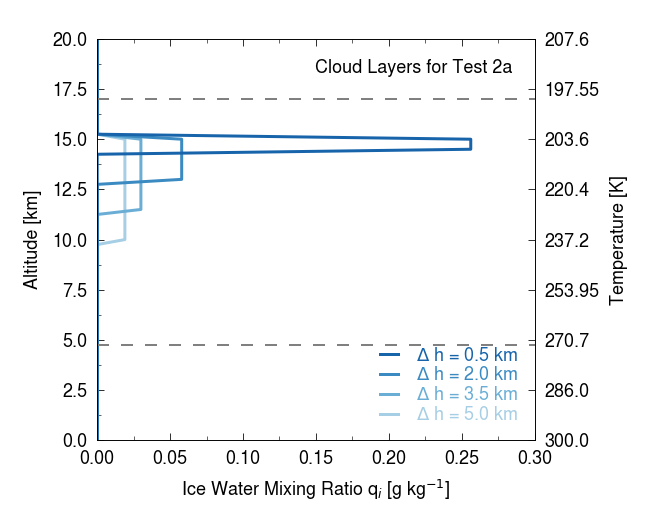

In [21]:
fontname  = 'Nimbus Sans'
fontsize  = 18
my_colors = [(88/255,148/255,197/255), (169/255,23/255,38/255),
             (229/255,179/255,69/255), (131/255,170/255,69/255),
             (116/255,24/255,123/255), (202/255,91/255,46/255),
             (107/255,188/255,233/255), 'grey']
length    = 9 # inches
heigth    = length*.8 # inches
f, ax     = plt.subplots(figsize = (length, heigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left = 0.15, right = 0.825)


handles = []
labels  = []
counter = 0
for i in [0,6,12,-1][::-1]:        
    h = ax.plot(q_ice[i]*1000, tropical_profile['height (km)'].iloc[::-1],
                linestyle = 'solid', linewidth = 3,
                color = cm.Blues(.35 + counter*.15), alpha = 1)
    handles = handles + h
    labels.append(r'$\Delta$ h = '+str(geom_depths[i])+' km')
    counter += 1

melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h5 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h6 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

# X Axis:
ax.set_xlabel(r'Ice Water Mixing Ratio q$_i$ [g kg$^{-1}$]', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_x = np.arange(-1,1,.05)
minor_ticks_x = np.arange(-1,1,.025)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(0, .3)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'x', which = 'minor',
#               color = 'black', size = 4,
#               direction = 'in', top = True)
    
# Y Axis:
ax.set_ylabel('Altitude [km]', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_y = np.arange(-20, 30, 2.5)
minor_ticks_y = np.arange(-20, 30, 1.25)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature [K]',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
ax2.tick_params(axis = 'x', which = 'minor',
                color = 'black', size = 4,
                direction = 'in', top = True)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.95, 0.95, 'Cloud Layers for Test 2a',
        fontname = fontname, fontsize = fontsize,
        color = 'black',
        ha = 'right', va = 'top', transform = ax.transAxes)

# Legend:
legend  = plt.legend(handles[::-1], labels[::-1], loc = 'lower right',#bbox_to_anchor=(.675, 1.075),#
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .1, labelcolor = 'linecolor',
                     handlelength = 1, handletextpad = 1,
                     prop = {'family': fontname, 'size':fontsize})

# Save Figure:
#out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig('paper_figures/fs06a.pdf', dpi = 300)

In [13]:
q_ice_6a = q_ice

### Final Table

In [22]:
ds = xr.Dataset(
    data_vars = dict(
        depth = (['column'], geom_depths),
        lw_emissivity = (['column'], lw_emissivity),
        sw_albedo = (['column'], sw_albedo),
        skin_temperature = (['column'], skin_temperature),
        cos_solar_zenith_angle = (['column'], cos_solar_zenith_angle),
        co2_vmr = (co2_vmr),
        ch4_vmr = (ch4_vmr),
        n2o_vmr = (n2o_vmr),
        o2_vmr  = (o2_vmr),
        pressure_hl = (['column', 'half_level'], pressure_hl),
        temperature_hl = (['column', 'half_level'], temperature_hl),
        q = (['column', 'level'], q),
        o3_mmr = (['column', 'level'], o3_mmr),
        q_liquid = (['column', 'level'], q_liquid),
        q_ice = (['column', 'level'], q_ice),
        re_liquid = (['column', 'level'], re_liquid),
        re_ice = (['column', 'level'], re_ice),
        cloud_fraction = (['column', 'level'], cloud_fraction),
    ),
    attrs = dict(
        title = "1D column input set for ecRad, Test 2a"),
)

In [23]:
out_dir1 = ('1-ecrad_inputs/')
out_dir2 = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
file     = 'input_1Dset_test2a_v7a.nc'
ds.to_netcdf(path = out_dir1 + file)
ds.to_netcdf(path = out_dir2 + file)

### 3.2 Test 2b: Geometrical Depth with fixed bottom level (10 km ~ 237.2 K)

In [14]:
cos_solar_zenith_angle = np.full(rows, .6)
lw_emissivity          = np.full(rows, .97)
sw_albedo              = np.full(rows, .05)
skin_temperature       = np.full(rows, temp.iloc[-1]) # (K)

re = 30 # Effective radious (um)

# Specific humidity matrix (perturbations X level):
qi = tropical_profile['specific hum\t(kg/kg)'].iloc[::-1]
q  = np.full((rows, len(pressure_hli)-1), qi)

# Gases as one scalar (from current ICON running in levante, representative for 2012 values)
co2_vmr = 390.1e-6 # Volume mixing ratio mol mol^-1
ch4_vmr = 1.8e-6   # Volume mixing ratio mol mol^-1
n2o_vmr = 322e-9   # Volume mixing ratio mol mol^-1
o2_vmr  = 0.20946  # Volume mixing ratio mol mol^-1

# Ozone mass mixing ratio matrix (perturbations X level):
o3_mmr = np.zeros((rows, len(pressure_hli)-1))

# Liquid cloud mass mixing ratio (perturbations X level):
q_liquid = np.zeros((rows, len(pressure_hli)-1))

# Ice cloud mass mixing ratio (perturbations X level):
q_ice = np.zeros((rows, len(pressure_hli)-1))

cloud_fraction = np.zeros((rows, len(pressure_hli)-1))

# CREATING THE PROFILE     
for i in range(rows): # rows with different geometrical depths ("column" dimension for final matrix)
    for j in range(len(altitude)): # columns with vertical profiles ("level" dimension for final matrix)
        hj = altitude.iloc[j]
        lower_limit_h = altitude.index.get_loc(altitude[altitude == 10].index[0])
        upper_limit_h = altitude.index.get_loc(altitude[altitude == (10 + geom_depths[::-1][i])].index[0]) # fixed
        if hj >= 10 and hj <= (10 + geom_depths[::-1][i]):
            integral = np.trapz(density.iloc[upper_limit_h:lower_limit_h+1],
                                altitude.iloc[upper_limit_h:lower_limit_h+1]*1000,0.1)
            q_ice[i,j] = (30/abs(integral))*1e-3 # qi = IWP / int(rho dz) kg/kg
            cloud_fraction[i,j] = 1
    
# Liquid cloud effective radius (m):
re_liquid = np.full((rows, len(pressure_hli)-1), 1e-5)

# Ice cloud effective radius (m):
re_ice = np.full((rows, len(pressure_hli)-1), re*1e-6)

# Half Level Pressures (perturbations X half_level):
pressure_hl = np.full((rows, len(pressure_hli)), pressure_hli)

# Half Level Temperatures (perturbations X half_level):
temperature_hl = np.full((rows, len(pressure_hli)), temperature_hli)

Checking:

In [15]:
lower_limit_h = altitude.index.get_loc(altitude[altitude == 10].index[0])
upper_limit_h = altitude.index.get_loc(altitude[altitude == (10 + geom_depths[::-1][0])].index[0]) # fixed

In [16]:
altitude.iloc[upper_limit_h:lower_limit_h+1]

60    15.00
59    14.75
58    14.50
57    14.25
56    14.00
55    13.75
54    13.50
53    13.25
52    13.00
51    12.75
50    12.50
49    12.25
48    12.00
47    11.75
46    11.50
45    11.25
44    11.00
43    10.75
42    10.50
41    10.25
40    10.00
Name: height (km), dtype: float64

#### Figure S06b

<IPython.core.display.Javascript object>


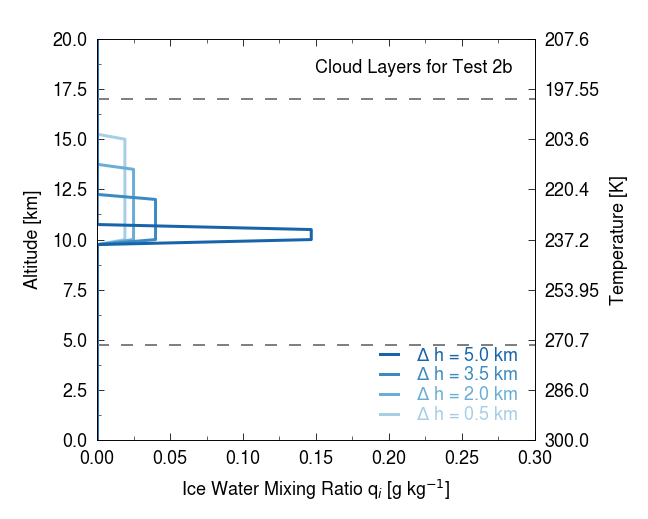

In [17]:
fontname  = 'Nimbus Sans'
fontsize  = 18
my_colors = [(88/255,148/255,197/255), (169/255,23/255,38/255),
             (229/255,179/255,69/255), (131/255,170/255,69/255),
             (116/255,24/255,123/255), (202/255,91/255,46/255),
             (107/255,188/255,233/255), 'grey']
length    = 9 # inches
heigth    = length*.8 # inches
f, ax     = plt.subplots(figsize = (length, heigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left = 0.15, right = 0.825)


handles = []
labels  = []
counter = 0
for i in [0,6,12,-1]:        
    h = ax.plot(q_ice[i]*1000, tropical_profile['height (km)'].iloc[::-1],
                linestyle = 'solid', linewidth = 3,
                color = cm.Blues(.35 + counter*.15), alpha = 1)
    handles = handles + h
    labels.append(r'$\Delta$ h = '+str(geom_depths[i])+' km')
    counter += 1

melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h5 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h6 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

# X Axis:
ax.set_xlabel(r'Ice Water Mixing Ratio q$_i$ [g kg$^{-1}$]',
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_x = np.arange(-1,1,.05)
minor_ticks_x = np.arange(-1,1,.025)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(0, .3)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'x', which = 'minor',
#               color = 'black', size = 4,
#               direction = 'in', top = True)
    
# Y Axis:
ax.set_ylabel('Altitude [km]', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_y = np.arange(-20, 30, 2.5)
minor_ticks_y = np.arange(-20, 30, 1.25)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature [K]',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
ax2.tick_params(axis = 'x', which = 'minor',
                color = 'black', size = 4,
                direction = 'in', top = True)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.95, 0.95, 'Cloud Layers for Test 2b',
        fontname = fontname, fontsize = fontsize,
        color = 'black',
        ha = 'right', va = 'top', transform = ax.transAxes)

# Legend:
legend  = plt.legend(handles[::-1], labels[::-1], loc = 'lower right',#bbox_to_anchor=(.675, 1.075),#
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .1, labelcolor = 'linecolor',
                     handlelength = 1, handletextpad = 1,
                     prop = {'family': fontname, 'size':fontsize})

# Save Figure:
#out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig('paper_figures/fs06b.pdf', dpi = 300)

In [18]:
q_ice_6b = q_ice

### Figure S06

<IPython.core.display.Javascript object>


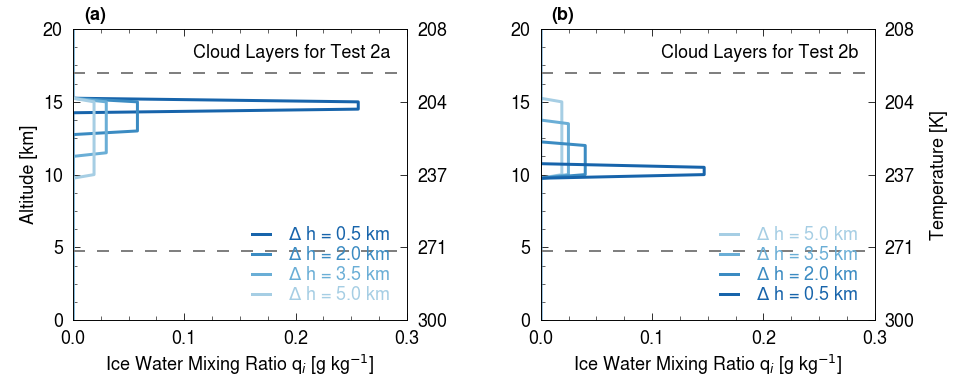

In [78]:
fontname  = 'Nimbus Sans'
fontsize  = 18
my_colors = [(88/255,148/255,197/255), (169/255,23/255,38/255),
             (229/255,179/255,69/255), (131/255,170/255,69/255),
             (116/255,24/255,123/255), (202/255,91/255,46/255),
             (107/255,188/255,233/255), 'grey']
length    = 13.5      # inches
heigth    = length*.4 # inches
f, ax     = plt.subplots(1, 2, figsize = (length, heigth), dpi = 72)
plt.subplots_adjust(top = 0.925, bottom = 0.175, left = 0.075, right = 0.9,
                    hspace = .35, wspace = .4)


handles_6a = []
labels_6a  = []
handles_6b = []
labels_6b  = []
counter = 0
for i in [0, 6, 12, -1]:        
    h_6a = ax[0].plot(q_ice_6a[i]*1000, tropical_profile['height (km)'].iloc[::-1],
                      linestyle = 'solid', linewidth = 3,
                      color = cm.Blues(.8 - counter*.15), alpha = 1)
    handles_6a = handles_6a + h_6a
    labels_6a.append(r'$\Delta$ h = '+str(geom_depths[i])+' km')
    
    h_6b = ax[1].plot(q_ice_6b[i]*1000, tropical_profile['height (km)'].iloc[::-1],
                      linestyle = 'solid', linewidth = 3,
                      color = cm.Blues(.35 + counter*.15), alpha = 1)
    handles_6b = handles_6b + h_6b
    labels_6b.append(r'$\Delta$ h = '+str(geom_depths[i])+' km')
    counter += 1

melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h_6a1 = ax[0].axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                      dashes = (6, 6), linewidth  =2)
h_6b1 = ax[1].axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                      dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h_6a2 = ax[0].axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                      dashes = (6, 6), linewidth  =2)
h_6b2 = ax[1].axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                      dashes = (6, 6), linewidth  =2)

ax[0].set_ylabel('Altitude [km]', 
                 fontname = fontname, fontsize = fontsize,
                 color = 'black', labelpad = 5)
for axi in range(2):
    # X Axis:
    ax[axi].set_xlabel(r'Ice Water Mixing Ratio q$_i$ [g kg$^{-1}$]',
                       fontname = fontname, fontsize = fontsize,
                       color = 'black', labelpad = 5)
    major_ticks_x = np.arange(-1, 1, .1)
    minor_ticks_x = np.arange(-1, 1, .025)
    ax[axi].set_xticks(major_ticks_x)
    ax[axi].set_xticks(minor_ticks_x, minor=True)
    ax[axi].set_xlim(0, .3)
    ax[axi].tick_params(axis = 'x', which = 'major', color = 'black',
                        size = 7, direction = 'in', top = True,
                        labelsize = fontsize, pad = 10)
    ax[axi].tick_params(axis = 'x', which = 'minor',
                        color = 'black', size = 4,
                        direction = 'in', top = True)
    for tick in ax[axi].get_xticklabels():
        tick.set_fontname(fontname)

    # Y Axis:
    major_ticks_y = np.arange(-20, 30, 5)
    minor_ticks_y = np.arange(-20, 30, 1.25)
    ax[axi].set_yticks(major_ticks_y)
    ax[axi].set_yticks(minor_ticks_y, minor=True)
    ax[axi].set_ylim(0, 20)
    ax[axi].tick_params(axis = 'y', which = 'major', color = 'black',
                        size = 7, direction = 'in', right = True,
                        labelsize = fontsize, pad = 10)
    ax[axi].tick_params(axis = 'y', which = 'minor',
                        color = 'black', size = 4,
                        direction = 'in', top = True)
    for tick in ax[axi].get_yticklabels():
        tick.set_fontname(fontname)
    #ax.tick_params(axis = 'y', which = 'minor', color = 'black',
    #               size = 4, direction = 'in', right = True)

# Right Y Axis:
# ax2 = np.zeros(2)
# ax2[0] = ax[0].twinx()
# ax2[1] = ax[1].twinx()
for axi in range(2):
    ax2 = ax[axi].twinx()
    yticklabels1 = np.arange(0, 22.5, 5) # default altitude tick labels
    yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].round(0).astype(int).to_list()
    ax2.set_yticks(yticklabels1)
    ax2.set_yticklabels(yticklabels2)
    ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                    size = 7, direction = 'in', right = True,
                    labelsize = fontsize, pad = 10)
    ax2.tick_params(axis = 'x', which = 'minor',
                    color = 'black', size = 4,
                    direction = 'in', top = True)
    for tick in ax2.get_yticklabels():
        tick.set_fontname(fontname)
ax2.set_ylabel('Temperature [K]',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 15)
        
ax[0].text(0.95, 0.95, 'Cloud Layers for Test 2a',
           fontname = fontname, fontsize = fontsize,
           color = 'black',
           ha = 'right', va = 'top', transform = ax[0].transAxes)
ax[1].text(0.95, 0.95, 'Cloud Layers for Test 2b',
           fontname = fontname, fontsize = fontsize,
           color = 'black',
           ha = 'right', va = 'top', transform = ax[1].transAxes)

# Legend:
legend  = ax[0].legend(handles_6a, labels_6a, loc = 'lower right',#bbox_to_anchor=(.675, 1.075),#
                       frameon = False, ncol = 1, columnspacing = 2,
                       labelspacing = .1, labelcolor = 'linecolor',
                       handlelength = 1, handletextpad = 1,
                       prop = {'family': fontname, 'size':fontsize})
legend  = ax[1].legend(handles_6b, labels_6b[::-1], loc = 'lower right',#bbox_to_anchor=(.675, 1.075),#
                       frameon = False, ncol = 1, columnspacing = 2,
                       labelspacing = .1, labelcolor = 'linecolor',
                       handlelength = 1, handletextpad = 1,
                       prop = {'family': fontname, 'size':fontsize})

ax[0].text(0.1, 1.075, '(a)', weight = 'bold',
           ha = 'right', va = 'top', transform = ax[0].transAxes,
           fontsize = fontsize, fontname = fontname, color = 'black')
ax[1].text(0.1, 1.075, '(b)', weight = 'bold',
           ha = 'right', va = 'top', transform = ax[1].transAxes,
           fontsize = fontsize, fontname = fontname, color = 'black')

# Save Figure:
#out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
plt.savefig('paper_figures/fs06.pdf', dpi = 300)

### Final Table

In [32]:
ds = xr.Dataset(
    data_vars = dict(
        depth = (['column'], geom_depths),
        lw_emissivity = (['column'], lw_emissivity),
        sw_albedo = (['column'], sw_albedo),
        skin_temperature = (['column'], skin_temperature),
        cos_solar_zenith_angle = (['column'], cos_solar_zenith_angle),
        co2_vmr = (co2_vmr),
        ch4_vmr = (ch4_vmr),
        n2o_vmr = (n2o_vmr),
        o2_vmr  = (o2_vmr),
        pressure_hl = (['column', 'half_level'], pressure_hl),
        temperature_hl = (['column', 'half_level'], temperature_hl),
        q = (['column', 'level'], q),
        o3_mmr = (['column', 'level'], o3_mmr),
        q_liquid = (['column', 'level'], q_liquid),
        q_ice = (['column', 'level'], q_ice),
        re_liquid = (['column', 'level'], re_liquid),
        re_ice = (['column', 'level'], re_ice),
        cloud_fraction = (['column', 'level'], cloud_fraction),
    ),
    attrs = dict(
        title = '1D column input set for ecRad, Test 2b'),
)

In [33]:
out_dir1 = ('1-ecrad_inputs/')
out_dir2 = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
file     = 'input_1Dset_test2b_v7a.nc'
ds.to_netcdf(path = out_dir1 + file)
ds.to_netcdf(path = out_dir2 + file)